In [20]:
import pandas as pd
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt


import glob
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse
from scipy.sparse.linalg import svds


from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df_text_ic = pd.read_csv('../data/df_text_ic.csv')

In [19]:
df_text_ic.shape #(263941, 32)
df_text_ic.head()
# df_text_ic = df_text_ic.drop(['Unnamed: 0.1', 'Unnamed: 0'])
df_text_ic.columns

df_text_ic.head()
df_text_ic.shape #(263941, 30)
df_text_ic.columns

Index(['subject_id', 'hadm_id', 'icd', 'long_title', 'chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction', 'icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85'],
      dtype='object')

In [54]:
df_text_ic.head()

,subject_id,hadm_id,icd,long_title,chief_complaint,surgical_invasive_procedure,history_present_illness,past_medcal_history,social_history,family_history,...,followup_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,10000980,29654838,I50,"Congestive heart failure, unspecified",Shortness of breath\n,None\n,"___ yo woman with h/o hypertension, hyperlipid...","1. CAD RISK FACTORS: +Diabetes, +Dyslipidemia,...",___,Denies cardiac family history. Family hx of DM...,...,___\n,1,1,0,0,0,1,0,0,0
1,10000980,26913865,I50,Acute on chronic systolic heart failure,dyspnea\n,Cardiac catheterization ___\n\n,"This is a ___ M with history of diabetes, dias...",- hypertension\n- diabetes\n- hx CVA (cerebell...,___,"Niece had some sort of cancer. Otherwise, no f...",...,___\n,1,0,0,0,0,1,0,0,0
2,10000980,24947999,I50,Acute on chronic systolic heart failure,Dyspnea and chest tightness\n,___ Pharmacologic nuclear stress test\n,"___ year old female with history of HTN, HLD, ...",- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,1,0,0,0,1,0,0,0
3,10000980,25242409,I50,"Congestive heart failure, unspecified",DVT\n,EGD\n\n,This is a ___ y/o female with PMHx significant...,- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,1,0,0,0,1,1,1,0
4,10000980,25911675,I50,Acute on chronic systolic (congestive) heart f...,"fatigue, anemia\n",None\n\n,Ms. ___ is a ___ year old woman with a past me...,- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,0,0,0,0,1,0,0,0


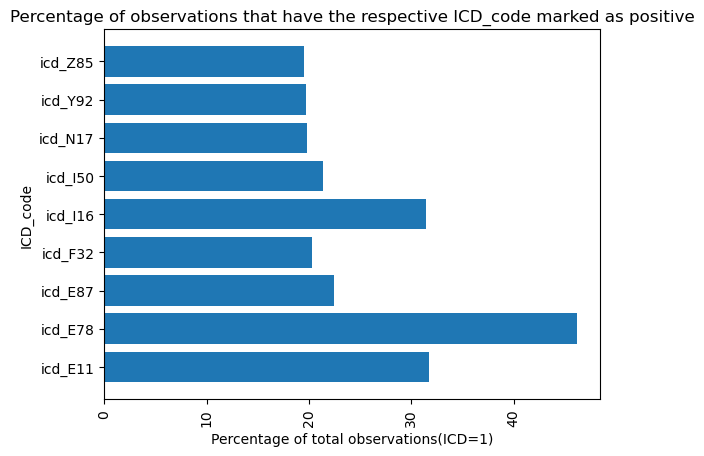

In [37]:
df = (((df_text_ic[['icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85']].sum())*100)/len(df_text_ic)).to_frame().reset_index().rename(columns={'index': 'ICD_code',
                                                                                         0: 'percent_Count'})

plt.barh(df.ICD_code, df.percent_Count)
plt.xticks(rotation=90)
plt.xlabel("Percentage of total observations(ICD=1)")
plt.ylabel("ICD_code")
plt.title("Percentage of observations that have the respective ICD_code marked as positive")
plt.show()

In [53]:
#length of the string in text per column

text_cat = ['chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']

len_dic = {}
for i in text_cat:
    avg_length = df_text_ic[i].str.len().mean()

    len_dic[i] = avg_length
    print(i, avg_length)
# pd.DataFrame(len_dic)

chief_complaint 26.63749872512023
surgical_invasive_procedure 43.27068144111782
history_present_illness 1338.3546448150678
past_medcal_history 390.9412750578889
social_history 14.60800314123099
family_history 89.78513321685958
physical_exam 650.2739529922156
discharge 545.0770224864306
pertinent_results 1207.2725091447994
hospital_course 1871.7607907286717
medication_on_admission 439.7595137824651
medication_on_discharge 857.6061432389511
discharge_disposition 11.890147247143698
discharge_diagnosis 87.73823027125779
discharge_condition 127.02810335591379
discharge_instruction 813.5096734494198
followup_instruction 4.0


In [61]:
feature_text_length = (pd.DataFrame(len_dic, index=[0])).transpose().reset_index().rename(columns= {'index':'feature_category',
                                                                             0 : 'avg_length_of_text_string'})


,feature_category,avg_length_of_text_string
0,chief_complaint,26.637499
1,surgical_invasive_procedure,43.270681
2,history_present_illness,1338.354645
3,past_medcal_history,390.941275
4,social_history,14.608003
5,family_history,89.785133
6,physical_exam,650.273953
7,discharge,545.077022
8,pertinent_results,1207.272509
9,hospital_course,1871.760791


In [ ]:
target= ['icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85']
feature = [ 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']